# Rohit Chougule


# Customer Review Text Classification & Analysis

The customer ratings and reviews from different business categories are scraped from the website. The reviews are then stored in a csv file. Suitable Text cleaning, normalization, vectorization and analysis of the text is done. Further, the datasets are trained on different Machine Learning models to classify positive and negative reviews.

#### Library Imports

In [1]:
# Importing all the libraries and modules required in the project
import time
#Getting the start time when running the report
start_time = time.time()
import requests
import bs4
import csv
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
%matplotlib inline

## Data Gathering

In [2]:
# The base url for the web-page to be scraped
base_link="http://mlg.ucd.ie/modules/yalp/"
data_col_start = time.time()

In [3]:
# Function that fetches all the a tags from the web page to return the list having page name and their url
def get_list(link):
    response=requests.session()
    test=response.get(link)
    parser=bs4.BeautifulSoup(test.content, "html.parser")
    categories=[]
    for i in parser.find(id="all").find_all("a"):
        temp=[]
        temp.append(i.get_text())
        temp.append(i["href"])
        categories.append(temp)
    return categories

In [4]:
# Definition of function for getting the review content including the review text and the rating
def get_review(link):
    response=requests.session()
    test=response.get(link)
    parser=bs4.BeautifulSoup(test.content, "html.parser")
    reviews=[]
    for i in parser.find_all(class_="review"):
        temp=[]
        rating=(i.find('img', alt=True)['alt'])
        comment=(i.find(class_="review-text").get_text())
        temp.append(rating)
        temp.append(comment)
        reviews.append(temp)
        time.sleep(.03)
    return reviews

In [5]:
# Function to append the page-id at the end of the base-url
def get_entitylinks(entity_list):
    entity_list[1]=base_link+entity_list[1]
    return entity_list

In [6]:
# Function to fetch the list of business categories on the home page
def review_set(base_link):
    category_list=get_list(base_link)
    for category in category_list:
        get_entitylinks(category)
        get_list(category[1])
    return category_list

In [7]:
# Function call to get the set of review categories and its URL
category_list=review_set(base_link)

In [8]:
# Calling the review_set function to get the URL for each of the review category 
business_set1=review_set(category_list[1][1])
business_set2=review_set(category_list[5][1])
business_set3=review_set(category_list[6][1])

In [9]:
# Function to fetch the reviews from the business category called
def review_collection(business_set):
    reviews=[]
    for business in business_set:
        for review in (get_review(business[1])):
            reviews.append(review)
    return reviews

In [10]:
# Function to write the collected reviews to a csv file, in case of offline usage of the data
def write_data_tocsv(fileName, reviews):
    with open(fileName+'.csv', 'w', newline='', encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["rating","review"])
        writer.writerows(reviews)

#### Business Categories available for review classification

In [11]:
for i in range(0,7):
    business = str(category_list[i][0])
    print(i, business[10:])

0 Automotive
1 Cafes
2 Fashion
3 Gym
4 Hair and Salons
5 Hotels
6 Restaurants


From the above categories of businesses, Cafes, Hotels and Restaurants are the ones which belong to a similar industry. The customer reviews in these business categories may have a similarity in the words used in the text. i.e the corpus of these reviews may be a bit similar.
Selecting these categories can be helpful when training and testing the model on different datasets

In [12]:
# Function call to write thre reviews for business_set1
businessType = category_list[1][0]
fileName = (businessType[10:])
print("----------Writing "+fileName+" Business Reviews and ratings to a file----------")
reviews=review_collection(business_set1)
write_data_tocsv(fileName, reviews)

----------Writing Cafes Business Reviews and ratings to a file----------


In [13]:
# Function call to write thre reviews for business_set2
businessType = category_list[5][0]
fileName = (businessType[10:])
print("----------Writing "+fileName+" Business Reviews and ratings to a file----------")
reviews=review_collection(business_set2)
write_data_tocsv(fileName, reviews)

----------Writing Hotels Business Reviews and ratings to a file----------


In [14]:
# Function call to write thre reviews for business_set3
businessType = category_list[6][0]
fileName = (businessType[10:])
print("----------Writing "+fileName+" Business Reviews and ratings to a file----------")
reviews=review_collection(business_set3)
write_data_tocsv(fileName, reviews)

----------Writing Restaurants Business Reviews and ratings to a file----------


In [15]:
# Reading the csv for business_set1
dataset1 = pd.read_csv('Cafes.csv')

In [16]:
# Reading the csv for business_set1
dataset2 = pd.read_csv('Hotels.csv')

In [17]:
# Reading the csv for business_set1
dataset3 = pd.read_csv('Restaurants.csv')

In [18]:
data_col_end = time.time()

In [19]:
data_col_time  = (data_col_end - data_col_start)/60
data_col_time = round(data_col_time,2)
print("Time required to scrape and write the data to csv: "+ str(data_col_time) +" minutes.")

Time required to scrape and write the data to csv: 4.52 minutes.


In [20]:
dataset1.head()

,rating,review
0,4-star,Pros: Lots of items you would not expect from ...
1,4-star,Best egg-tarts in town! There's really not muc...
2,2-star,I've been to ABC Bakery a few times since I re...
3,1-star,"FYI, Closed Monday's New ownership for about 1..."
4,4-star,The inside may not look like much but they mak...


In [21]:
dataset2.head()

,rating,review
0,5-star,Melissa took us on a tour of Asia in the space...
1,5-star,With a group of seven of us visiting Montreal ...
2,5-star,Melissa is a gem! My fiancé found her tour on ...
3,5-star,A perfect day in Montreal! Melissa outfitted u...
4,5-star,I had a really great food truck tour with Meli...


In [22]:
dataset3.head()

,rating,review
0,2-star,My husband and I had a rare afternoon off so w...
1,4-star,For years I thought this was only a wine store...
2,5-star,This place is so charming! I went with my husb...
3,5-star,We have been wanting to try this place for a c...
4,1-star,Decor looks ok but layout is too busy. Difficu...


![alt text](sentiment.png)

## Data Cleaning

In [23]:
## Function to set the rating as positive or negative depending on the rating.
## Ratings <=3 are negative and ratings >3 are positive
def cleaning_review(dataset):
    positive_count = 0
    negative_count = 0
    for index,row in dataset.iterrows():
        customer_rating=(row["rating"])
        dataset.at[index, "rating"] = int(customer_rating[:1])
        if(dataset.at[index, "rating"] >3):
            dataset.at[index, "rating_type"] = "positive"
            positive_count=positive_count+1
        else:
            dataset.at[index, "rating_type"] = "negative"
            negative_count=negative_count+1
    return dataset, positive_count, negative_count

In [24]:
def dataset_class_skewnss_chart(positive_count, negative_count):
    fig = pyplot.figure()
    ax = fig.add_axes([0,0,1,1])
    y = [positive_count, negative_count]
    x=["positive","negative"]
    ax.bar(x,y)
    pyplot.title("Distribution of Class for the dataset (Type of Reviews)", fontSize=16)
    pyplot.xlabel("Type of Review", fontSize=14)
    pyplot.ylabel("Number of Reviews", fontSize=14)
    pyplot.show()

In [25]:
dataset1, positive_count, negative_count=cleaning_review(dataset1)

In [26]:
dataset1.head()

,rating,review,rating_type
0,4,Pros: Lots of items you would not expect from ...,positive
1,4,Best egg-tarts in town! There's really not muc...,positive
2,2,I've been to ABC Bakery a few times since I re...,negative
3,1,"FYI, Closed Monday's New ownership for about 1...",negative
4,4,The inside may not look like much but they mak...,positive


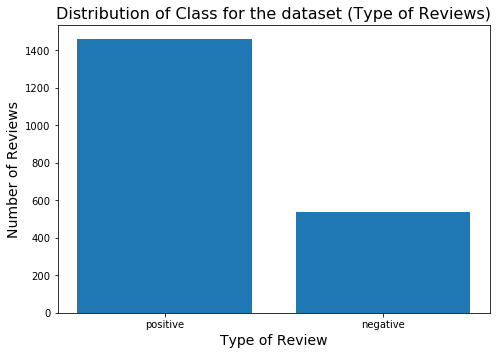

In [27]:
dataset_class_skewnss_chart(positive_count, negative_count)

In [28]:
dataset2, positive_count, negative_count=cleaning_review(dataset2)

In [29]:
dataset2.head()

,rating,review,rating_type
0,5,Melissa took us on a tour of Asia in the space...,positive
1,5,With a group of seven of us visiting Montreal ...,positive
2,5,Melissa is a gem! My fiancé found her tour on ...,positive
3,5,A perfect day in Montreal! Melissa outfitted u...,positive
4,5,I had a really great food truck tour with Meli...,positive


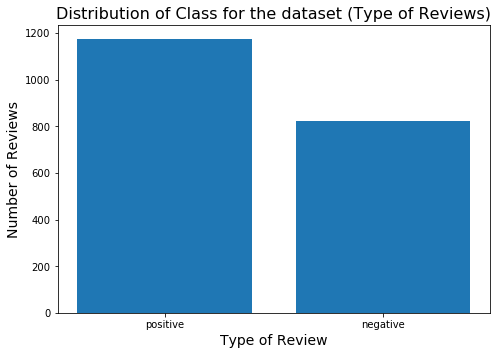

In [30]:
dataset_class_skewnss_chart(positive_count, negative_count)

In [31]:
dataset3, positive_count, negative_count=cleaning_review(dataset3)

In [32]:
dataset3.head()

,rating,review,rating_type
0,2,My husband and I had a rare afternoon off so w...,negative
1,4,For years I thought this was only a wine store...,positive
2,5,This place is so charming! I went with my husb...,positive
3,5,We have been wanting to try this place for a c...,positive
4,1,Decor looks ok but layout is too busy. Difficu...,negative


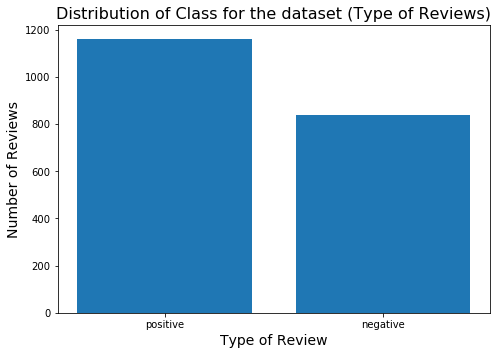

In [33]:
dataset_class_skewnss_chart(positive_count, negative_count)

In [34]:
# Function to count the percentage of puntuations in the text, before cleaning
def count_punct(review_text):
    count = sum([1 for char in review_text if char in string.punctuation])
    return round(count/(len(review_text) - review_text.count(" ")), 3)*100

In [35]:
# Function to lower the capitalized words, tokenizing words, removing stop words, 
# lemmatizing words in the review and returning the review
def clean_text_review(review_text):
    review_text = "".join([word.lower() for word in review_text if word not in string.punctuation and not word.isdigit()])
    review_text = review_text.strip()
    tokens = re.split('\W+', review_text)
    review = [word for word in tokens if word not in set(stopwords.words('english'))]
    wn = nltk.WordNetLemmatizer()
    review = [wn.lemmatize(word) for word in review]
    return review

In [36]:
# Function to get the length of the review text, and call punctuations percentage
# the length of text before cleaning is considered. (Actual review)
def review_length_punct(dataset):
    dataset['review_len'] = dataset['review'].apply(lambda x: len(x) - x.count(" "))
    dataset['punctuations'] = dataset['review'].apply(lambda x: count_punct(x))

In [37]:
review_length_punct(dataset1)
dataset1.head()

,rating,review,rating_type,review_len,punctuations
0,4,Pros: Lots of items you would not expect from ...,positive,1271,2.7
1,4,Best egg-tarts in town! There's really not muc...,positive,281,4.6
2,2,I've been to ABC Bakery a few times since I re...,negative,1275,4.9
3,1,"FYI, Closed Monday's New ownership for about 1...",negative,415,2.9
4,4,The inside may not look like much but they mak...,positive,235,3.4


In [38]:
review_length_punct(dataset2)
dataset2.head()

,rating,review,rating_type,review_len,punctuations
0,5,Melissa took us on a tour of Asia in the space...,positive,363,2.8
1,5,With a group of seven of us visiting Montreal ...,positive,380,3.9
2,5,Melissa is a gem! My fiancé found her tour on ...,positive,464,3.2
3,5,A perfect day in Montreal! Melissa outfitted u...,positive,360,3.3
4,5,I had a really great food truck tour with Meli...,positive,645,2.5


In [39]:
review_length_punct(dataset3)
dataset3.head()

,rating,review,rating_type,review_len,punctuations
0,2,My husband and I had a rare afternoon off so w...,negative,1106,4.2
1,4,For years I thought this was only a wine store...,positive,490,3.9
2,5,This place is so charming! I went with my husb...,positive,318,3.1
3,5,We have been wanting to try this place for a c...,positive,273,3.3
4,1,Decor looks ok but layout is too busy. Difficu...,negative,185,7.0


In [40]:
# Function to plot a histogram for comparing the length of positive and negative reviews in the dataset.
def histogram_reviewLength(dataset):
    bins = np.linspace(dataset["review_len"].min(), int(dataset["review_len"].mean()), int(dataset["review_len"].mean()/40))
    pyplot.hist(dataset[dataset['rating_type']=='positive']['review_len'], bins, alpha=0.5, label='positive')
    pyplot.hist(dataset[dataset['rating_type']=='negative']['review_len'], bins, alpha=0.5, label='negative')
    pyplot.legend(loc='upper right')
    pyplot.title("Length of Reviews in Dataset")
    pyplot.xlabel("Length of Review")
    pyplot.ylabel("Number of Reviews")
    pyplot.show()

In [41]:
# Function to plot a histogram for comparing the punctuation % of positive and negative reviews in the dataset.

def histogram_punctuations(dataset):
    #labels = ['negative','positive']
    bins = np.linspace(0, 10, 20)
    pyplot.hist(dataset[dataset['rating_type']=='positive']['punctuations'], bins, alpha=0.5, label='positive')
    pyplot.hist(dataset[dataset['rating_type']=='negative']['punctuations'], bins, alpha=0.5, label='negative')
    pyplot.title("Punctuation Percentage of Reviews")
    pyplot.xlabel("Punctuation Percentage")
    pyplot.ylabel("Number of Reviews")
    pyplot.legend(loc='upper right')
    pyplot.show()

#### tf-idf Vectorization of the text in the reviews

In [42]:
# Function for tf-idf vectorization of the reviews after cleaning the data
def review_Vectorization(dataset):
    #setting max features to top 2350 as most of the datasets here do not similar set features after vectorization
    tfidf_vect = TfidfVectorizer(analyzer=clean_text_review, max_features=2350)
    # Setting the max_features after thorough testing on different models
    X_tfidf = tfidf_vect.fit_transform(dataset['review'])
    X_features = pd.concat([dataset['review_len'], dataset['punctuations'], pd.DataFrame(X_tfidf.toarray())], axis=1)
    return X_features

## Text Analysis for Classification of reviews

### Dataset 1- Cafe Reviews

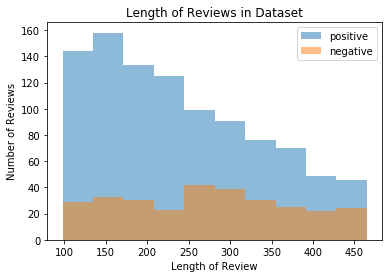

In [43]:
histogram_reviewLength(dataset1)

#### From the above histogram it can be interpreted that there are more number positive reviews which longer than the negative reviews in this Cafe Reviews.<br>The length of the review can be a usefule feature in the dataset for training a classification model.

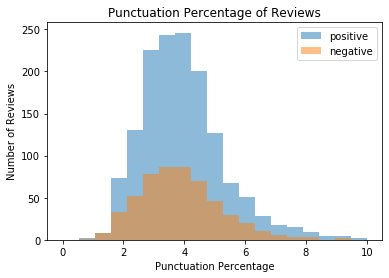

In [44]:
histogram_punctuations(dataset1)

#### From the above histogram we can iterpret that there are more number of positive reviews where the there is higher percentage of punctutations. Though there are a few negative reviews which have higher rate of punctuations. <br>The percentage of punctuations can also be a useful feature when training the classification model for this dataset. 

### Numeric Representation of the Data/Reviews

#### Normalization of review length and punctuation percentage

In [45]:
# Function to normalize the review length and punctuations attribute in the dataset
def _normalize_length_punct():
    scaler = MinMaxScaler()
    temp = X_features['review_len']
    temp = temp.to_numpy()
    temp = temp.reshape(-1,1)
    X_features['review_len'] = scaler.fit_transform(temp)
    scaler = MinMaxScaler()
    temp = X_features['punctuations']
    temp = temp.to_numpy()
    temp = temp.reshape(-1,1)
    X_features['punctuations'] = scaler.fit_transform(temp)

#### Vectorization of reviews in Dataset 1

In [46]:
X_features = review_Vectorization(dataset1)
## Saving the computed vectorized features considering future use for training
X_features_1 = X_features.copy()

In [47]:
X_features.head()

,review_len,punctuations,0,1,2,3,4,5,6,7,...,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349
0,1271,2.7,0.186419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,281,4.6,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1275,4.9,0.088271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,415,2.9,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,235,3.4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
_normalize_length_punct()

In [49]:
X_features.head()

,review_len,punctuations,0,1,2,3,4,5,6,7,...,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349
0,0.306266,0.024752,0.186419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.047781,0.048267,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.307311,0.051980,0.088271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.082768,0.027228,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.035770,0.033416,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Class Label for Dataset 1

In [50]:
y = dataset1['rating_type'].values

In [51]:
y

array(['positive', 'positive', 'negative', ..., 'negative', 'negative',
       'positive'], dtype=object)

### Splitting the Training and Testing Data

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size = 0.20, random_state = 25)

## Naive Bayes Classification Model

### Function to train and evaluate the Naive Bayes Classifier

In [53]:
# Function to train the Naive Bayes Classifier Model
def nBayesModel_train():
    nbModel = MultinomialNB()
    nbModel.fit(X_train, y_train)
    return nbModel

In [54]:
# Function to evaluate the Naive Bayes Classifier Model
def evaluate_NB(model, test_features, test_labels):
    predictions = model.predict(test_features)
    precision, recall, fscore, support = score(test_labels, predictions, pos_label='positive', average='binary')
    accuracy = model.score(test_features, test_labels)
    tn, fp, fn, tp = confusion_matrix(test_labels,predictions).ravel()
    print("------------ Naive Bayes Classifier Performance Metrics ------------")
    print("F-score: {} ".format(round(fscore,3)*100))
    print("Precision: {} ".format(round(precision,3)*100))
    print("Recall: {} ".format(round(recall,3)*100))
    print("Accuracy: {} ".format(round(accuracy,3)*100))
    nbMetrics = [precision, recall, fscore, accuracy, tn, fp, fn, tp]
    return nbMetrics

#### Naive Bayes Classifier training

In [55]:
nb_start_time = time.time()
nb_Model = nBayesModel_train()
nb_end_time = time.time()

In [56]:
nb_train_time = (nb_end_time - nb_start_time)
nb_train_time = round(nb_train_time,2)
print("Time required to train Naive Bayes Classifier: " + str(nb_train_time) +" seconds")

Time required to train Naive Bayes Classifier: 0.03 seconds


#### Naive Bayes Classifier Model evaluation metrics

In [57]:
nbMetrics = evaluate_NB(nb_Model, X_test, y_test)

------------ Naive Bayes Classifier Performance Metrics ------------
F-score: 88.9 
Precision: 80.7 
Recall: 99.0 
Accuracy: 81.8 


## RandomForest Classification Model

#### Functions to train RandomForest Classifier with RandomSearchCV for the best suited parameters

In [58]:
#Setting a range of parameters to be used in the randomforest classifier to find the best suited parameter for the model
# Number of trees in random forest
n_estimators = [int(x) for x in range(200, 4000, 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', "None"]
# Maximum number of levels in tree
max_depth = [int(x) for x in range(100, 500, 10)]
max_depth.append(None)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth
              }

#### RandomSearchCV to look for the best hyper-parameters for the random forest classifier

In [59]:
# Using the random grid to search for best hyperparameters in the random forest classifier
rf = RandomForestClassifier()
# Random search of parameters, using default 5 fold cross validation, 
# search across different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [60]:
## The best parameters found for the random forest
rf_random.best_params_

{'n_estimators': 3290, 'max_features': 'auto', 'max_depth': 380}

#### Function for training RandomForest Classifier using the best found hyper-parameters

In [61]:
# Function to train the Random Forest Model
def rforestModel_train():
    n_estimators = rf_random.best_params_["n_estimators"]
    max_depth = rf_random.best_params_["max_depth"]
    max_features = rf_random.best_params_["max_features"]
    rf_Model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, 
                                    max_features = max_features)
    rf_Model.fit(X_train, y_train)
    return rf_Model

#### RandomForest Classifier Evaluation function

In [62]:
# Function to evaluate the random forest model
def evaluate_RF(model, test_features, test_labels, n_est, depth):
    predictions = model.predict(test_features)
    precision, recall, fscore, support = score(test_labels, predictions, pos_label='positive', average='binary')
    accuracy = model.score(test_features, test_labels)
    tn, fp, fn, tp = confusion_matrix(test_labels,predictions).ravel()
    print("------------ Random Forest Classifier Performance Metrics ------------")
    print("F-score: {} ".format(round(fscore,3)*100))
    print("Precision: {} ".format(round(precision,3)*100))
    print("Recall: {} ".format(round(recall,3)*100))
    print("Accuracy: {} ".format(round(accuracy,3)*100))
    rfMetrics = [precision, recall, fscore, accuracy, tn, fp, fn, tp]
    return rfMetrics

#### Training RandomForest Classifier on Dataset - 1

In [63]:
rf_start_time = time.time()
rf_Model = rforestModel_train()
rf_end_time = time.time()

In [64]:
rf_train_time = (rf_end_time - rf_start_time)
rf_train_time = round(rf_train_time,2)
print("Time required to train Random Forest Classifier: " + str(rf_train_time) + " seconds")

Time required to train Random Forest Classifier: 64.23 seconds


#### Evaluation of RandomForest Classifier Metrics

In [65]:
rfMetrics = evaluate_RF(rf_Model, X_test, y_test, n_estimators, max_depth)

------------ Random Forest Classifier Performance Metrics ------------
F-score: 91.10000000000001 
Precision: 84.8 
Recall: 98.3 
Accuracy: 85.8 


## Logistic Regression Classification Model

#### Function to train Logistic Regression model

In [66]:
# Function to train the Logistic Regression Model
def logRegModel_train():
    logReg = LogisticRegression(solver='liblinear', C=5, penalty='l2',max_iter=3000)
    logReg.fit(X_train,y_train)
    return logReg

#### Function to evaluate Logistic Regression Model

In [67]:
# Function to evaluate the Logistic Regression Model
def evaluate_LogReg(model, test_features, test_labels):
    predictions = model.predict(test_features)
    precision, recall, fscore, support = score(test_labels, predictions, pos_label='positive', average='binary')
    accuracy = model.score(test_features, test_labels)
    tn, fp, fn, tp = confusion_matrix(test_labels,predictions).ravel()
    print("------------ Logistic Regression Classifier Performance Metrics ------------")
    print("F-score: {} ".format(round(fscore,3)*100))
    print("Precision: {} ".format(round(precision,3)*100))
    print("Recall: {} ".format(round(recall,3)*100))
    print("Accuracy: {} ".format(round(accuracy,3)*100))
    logRegMetrics = [precision, recall, fscore, accuracy, tn, fp, fn, tp]
    return logRegMetrics

#### Training Logistic Regression Model on Dataset - 1 

In [68]:
lr_start_time = time.time()
logReg_Model = logRegModel_train()
lr_end_time = time.time()

In [69]:
lr_train_time = (lr_end_time - lr_start_time)
lr_train_time = round(lr_train_time,2)
print("Time required to train Logistic Regression Classifier: " + str(lr_train_time)+ " seconds")

Time required to train Logistic Regression Classifier: 0.11 seconds


#### Logistic Regression Model evaluation metrics

In [70]:
logRegMetrics_1 = evaluate_LogReg(logReg_Model, X_test, y_test)

------------ Logistic Regression Classifier Performance Metrics ------------
F-score: 92.5 
Precision: 89.3 
Recall: 95.89999999999999 
Accuracy: 88.5 


## Classifier Evaluation 

Comparing Naive Bayes Classifier, RandomForest Classifier, and Logistic Regression Classification Metrics for training and testing on reviews for Dataset - 1

In [71]:
classifierEvaluation = pd.DataFrame({
    'Naive Bayes': nbMetrics,
    'Random Forest': rfMetrics,
    'Logistic Regression': logRegMetrics_1
}, index=['precision', 'recall', 'fscore', 'accuracy','true negatives','false positives','false negatives','true positives']
).T
classifierEvaluation["precision"] = round(classifierEvaluation["precision"]*100,2)
classifierEvaluation["recall"] = round(classifierEvaluation["recall"]*100,2)
classifierEvaluation["fscore"] = round(classifierEvaluation["fscore"]*100,2)
classifierEvaluation["accuracy"] = round(classifierEvaluation["accuracy"]*100,2)

#### The below table shows evaluation metrics for each of the Classifier models.

In [72]:
classifierEvaluation.head()

,precision,recall,fscore,accuracy,true negatives,false positives,false negatives,true positives
Naive Bayes,80.72,98.99,88.92,81.75,34.0,70.0,3.0,293.0
Random Forest,84.84,98.31,91.08,85.75,52.0,52.0,5.0,291.0
Logistic Regression,89.31,95.95,92.51,88.50,70.0,34.0,12.0,284.0


In [73]:
## Function for 5- fold Cross validation score on accuracy of the model
def cv_score_mean(model,X,y):
    X = X[:250]
    y = y[:250]
    cv_score = (cross_val_score(model, X, y, cv=None, scoring="accuracy"))
    avg_cv_score = cv_score.mean()*100
    avg_cv_score = round(avg_cv_score,2)
    print("The average accuracy of the model on 5-fold cross validation is: "+str(avg_cv_score))

In [74]:
cv_score_mean(logReg_Model,X_test,y_test)

The average accuracy of the model on 5-fold cross validation is: 77.2


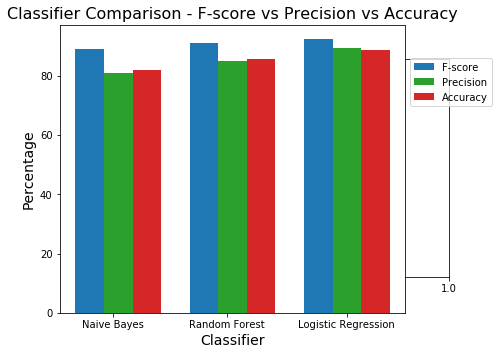

In [75]:
_fscore = classifierEvaluation["fscore"].to_numpy()
_precision = classifierEvaluation["precision"].to_numpy()
_accuracy = classifierEvaluation["accuracy"].to_numpy()

X = np.arange(3)

ticks = ['Naive Bayes', 'Random Forest', 'Logistic Regression']
fig = pyplot.figure()
ax = pyplot.subplot(111)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0, _fscore, color = 'tab:blue', width = 0.25,align="center")
ax.bar(X + 0.25, _precision, color = 'tab:green', width = 0.25,align="center")
ax.bar(X + 0.50, _accuracy, color = 'tab:red', width = 0.25,align="center")
ax.set_ylabel("Percentage",fontsize=14)
ax.set_xlabel("Classifier",fontsize=14)
pyplot.title("Classifier Comparison - F-score vs Precision vs Accuracy",fontsize=16)
pyplot.xticks([0.20,1.2,2.25], ticks)
ax.set_xticklabels(ticks, rotation=0, rotation_mode="anchor")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

pyplot.legend(['F-score', 'Precision','Accuracy'], bbox_to_anchor=(1, 0.8), loc='center left')
pyplot.show()

From the above combination of Line chart and bar chart visualizations for the Classifiers evaluation metrics, it is observed that the accuracy and f-score of all the models trained and tested on the dataset 1 are almost the same with a minor difference of about 1-2%, where Logisitic regression has the highest F-score and accuracy.<br>Whereas, in terms of precision of the Logistic Regression it is a bit higher than the other models by 4-5%.<br>In this context of Classification Model training on customer reviews for businesses, I believe the important factor for selection of model should be focusing on the correct classification Negative reviews. Any business usually is customer centric and the feedback of the customer is an important aspect to improve the business. A customer that has a negative review about a business can be approached by the business owner and his/her discrepancies about the reviews can be cleared. The business owners can reach out to the customers with negative reviews for details on improvement, following up with those customers and hence not loose a customer.

Therefore, I believe correct classification of negative reviews may be considered important.<br> With regards to the Classification Model selection, it is important to select a model that has **less False Positives**.<br>
A model that has fairly less **False Positive Rate**, i.e a negative review should not be classified as positive, as this may lead to missout on the looking for actual negative customer reviews.

#### The below bar chart compares the True Positive rates(TP-rate) and False Positive rates(FP-rate) for each of the Classifier Models

In [76]:
def tp_rate_chart(classifierEvaluation, xlab):
    tp_rate  = classifierEvaluation["true positives"] / (classifierEvaluation["false negatives"] 
                                                            + classifierEvaluation["true positives"])
    pyplot.bar(classifierEvaluation.index, tp_rate * 100)
    pyplot.title("(TP-rate) Sensitivity of the model")
    pyplot.xlabel(xlab)
    pyplot.ylabel("True Positive Rate")
    pyplot.show()

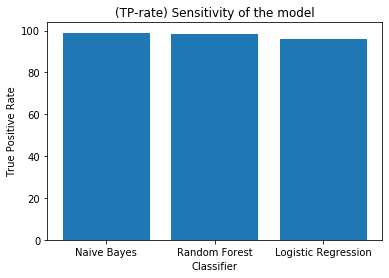

In [77]:
tp_rate_chart(classifierEvaluation, "Classifier")

In [78]:
def fp_rate_chart(classifierEvaluation, xlab):
    fp_rate  = classifierEvaluation["false positives"] / (classifierEvaluation["false positives"] 
                                                            + classifierEvaluation["true negatives"])
    pyplot.bar(classifierEvaluation.index, fp_rate * 100)
    pyplot.title("False Positives Rate of the model")
    pyplot.xlabel(xlab)
    pyplot.ylabel("False Positive Rate")
    pyplot.show()

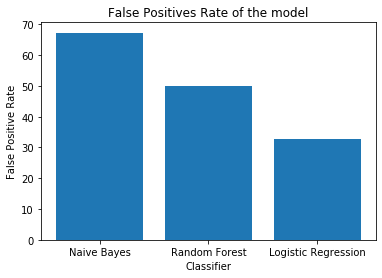

In [79]:
fp_rate_chart(classifierEvaluation, "Classifier")

From the above two charts for the TP-rate and FP-rate of the classifiers, it is observed that the TP-rate of all the classifiers is almost similar, though the logistic regression model has a bit less(about 1%) than others. But, true positives are those which are actual positive reviews and classified as postive.<br>
However, from ***the FP-rate graph for each model, it can be observed that the FP-rate of Logistic Regression is significantly less than other two classifiers.***<br>
**The Logistic Regression classifier has a bit higher accuracy, fscore, precision than other classifiers.**
<br>
A model that has high TP rate and low FP rate would be an ideal model in this scenario.<br>
**As discussed above, in classification of the customer reviews, we need to focus on reducing false positives while also considering other metrics like accuracy, precision, f-score.**<br>

Therefore, I will be using a Logistic Regression Model for classification of the reviews by training and testing on different customer review datasets.

### Text Review Analysis for Dataset 2- Hotels with Logistic Regression Model Trained on Dataset 1

#### Testing Logistic Regression Model on Dataset 2, Model trained on Dataset 1

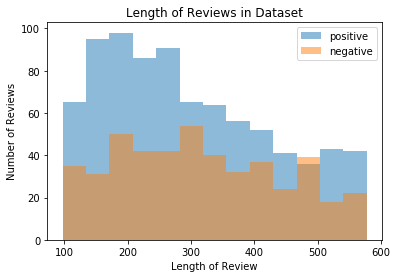

In [80]:
histogram_reviewLength(dataset2)

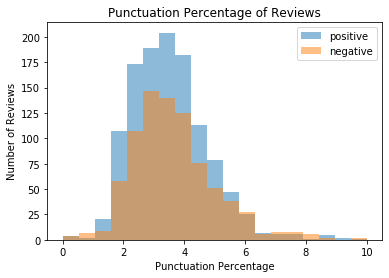

In [81]:
histogram_punctuations(dataset2)

Both the histograms from the dataset depict that more number of positive reviews tend to be longer, though the punctuation percentage seems to be almost same for both type of reviews

In [82]:
X_features = review_Vectorization(dataset2)
## Saving the computed vectorized features considering future use for training
X_features_2 = X_features.copy()

In [83]:
X_features.head()

,review_len,punctuations,0,1,2,3,4,5,6,7,...,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349
0,363,2.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,380,3.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,464,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,360,3.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,645,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
_normalize_length_punct()

In [85]:
X_features.head()

,review_len,punctuations,0,1,2,3,4,5,6,7,...,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349
0,0.068153,0.198582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.072508,0.276596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.094030,0.226950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.067384,0.234043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.140405,0.177305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
y = dataset2['rating_type'].values

Setting the entire X_features and y of Dataset-2 Hotels as X_test, and y_test for the Logistic Regression model trained on Dataset 1

In [87]:
y
y_test=y
X_test=X_features

In [88]:
logRegMetrics_2 = evaluate_LogReg(logReg_Model, X_test, y_test)

------------ Logistic Regression Classifier Performance Metrics ------------
F-score: 71.5 
Precision: 59.5 
Recall: 89.60000000000001 
Accuracy: 57.99999999999999 


In [89]:
cv_score_mean(logReg_Model,X_test,y_test)

The average accuracy of the model on 5-fold cross validation is: 85.2


### Text Review Analysis for Dataset 3- Restaurants with Logistic Regression Model Trained on Dataset 1

#### Testing Logistic Regression Model on Dataset 3, Model trained on Dataset 1

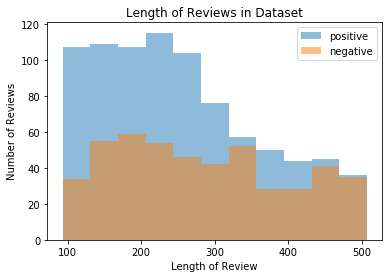

In [90]:
histogram_reviewLength(dataset3)

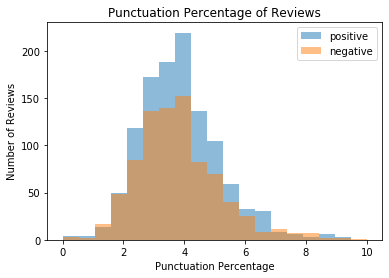

In [91]:
histogram_punctuations(dataset3)

From the above two histograms, it can be clearly found that there is a significant difference in the number of positive reviews that are lengthy and negative reviews that are lengthy. Also the difference in the number of reviews for percentage of punctuations is considerable.
These two features can play an important part in training a model on this dataset in the last part of this project.

In [92]:
X_features = review_Vectorization(dataset3)
## Saving the computed vectorized features considering future use for training
X_features_3 = X_features.copy()

In [93]:
X_features.head()

,review_len,punctuations,0,1,2,3,4,5,6,7,...,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349
0,1106,4.2,0.0,0.0,0.0,0.0,0.069229,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,490,3.9,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,318,3.1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,273,3.3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,185,7.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
_normalize_length_punct()

In [95]:
X_features.head()

,review_len,punctuations,0,1,2,3,4,5,6,7,...,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349
0,0.254395,0.291667,0.0,0.0,0.0,0.0,0.069229,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.099699,0.270833,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.056504,0.215278,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.045203,0.229167,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.023104,0.486111,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
y = dataset3['rating_type'].values

Setting the entire X_features and y of Dataset-3 Restaurants as X_test, and y_test for the Logistic Regression model trained on Dataset 1

In [97]:
y
y_test=y
X_test=X_features

In [98]:
logRegMetrics_3 = evaluate_LogReg(logReg_Model, X_test, y_test)

------------ Logistic Regression Classifier Performance Metrics ------------
F-score: 71.8 
Precision: 58.599999999999994 
Recall: 92.80000000000001 
Accuracy: 57.699999999999996 


In [99]:
cv_score_mean(logReg_Model,X_test,y_test)

The average accuracy of the model on 5-fold cross validation is: 80.8


In [100]:
# Saving metrics for all the datasets tested on Logistic Regression Model - 1
ModelEvaluation_1 = pd.DataFrame({
    'Dataset 1': logRegMetrics_1,
    'Dataset 2': logRegMetrics_2,
    'Dataset 3': logRegMetrics_3
}, index=['precision', 'recall', 'fscore', 'accuracy','true negatives','false positives','false negatives','true positives']
).T
ModelEvaluation_1["precision"] = round(ModelEvaluation_1["precision"]*100,2)
ModelEvaluation_1["recall"] = round(ModelEvaluation_1["recall"]*100,2)
ModelEvaluation_1["fscore"] = round(ModelEvaluation_1["fscore"]*100,2)
ModelEvaluation_1["accuracy"] = round(ModelEvaluation_1["accuracy"]*100,2)

### Classification Evaluation

#### Model Trained on Dataset 1, tested on Dataset 2 and Dataset 3

In [101]:
ModelEvaluation_1

,precision,recall,fscore,accuracy,true negatives,false positives,false negatives,true positives
Dataset 1,89.31,95.95,92.51,88.5,70.0,34.0,12.0,284.0
Dataset 2,59.48,89.63,71.51,58.0,106.0,718.0,122.0,1054.0
Dataset 3,58.59,92.77,71.82,57.7,76.0,762.0,84.0,1078.0


From the above table for metrics of the model tested on each of the dataset, it is observed that the highest precision and accuracy is for the Dataset 1, on which the model is trained. Whereas the metrics of the model when tested on other datasets the precision and accuracy are comparitively less, but considerable.<br> Also the number of false positives in the model for the Dataset 2 and Dataset 3 are comparitively on higher side. A model that is having relatively low FP rate would be an ideal in this scenario

A detailed comparison of a Logistic Regression Model trained on different datasets and their evaluation of testing on different datasets is done in the last section of this project.

## Training Logistic Regression Model on Dataset 2 - "Hotels"

In [102]:
## Assigning the X_features with the vectorized feature values stored in X_features_2 copy
X_features = X_features_2
X_features.head()

,review_len,punctuations,0,1,2,3,4,5,6,7,...,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349
0,363,2.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,380,3.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,464,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,360,3.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,645,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
# Call to normalization function.
_normalize_length_punct()

In [104]:
X_features.head()

,review_len,punctuations,0,1,2,3,4,5,6,7,...,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349
0,0.068153,0.198582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.072508,0.276596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.094030,0.226950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.067384,0.234043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.140405,0.177305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
y = dataset2['rating_type'].values

#### Splitting the Data in to training and test set

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size = 0.20, random_state = 25)

#### Training Logisitic Regression Model on Dataset 2- Hotels

In [107]:
# Call to the function to train the Logistic Regression Model on dataset 2
logReg_Model = logRegModel_train()

In [108]:
logRegMetrics_2 = evaluate_LogReg(logReg_Model, X_test, y_test)

------------ Logistic Regression Classifier Performance Metrics ------------
F-score: 91.3 
Precision: 87.9 
Recall: 95.0 
Accuracy: 90.0 


In [109]:
cv_score_mean(logReg_Model,X_test,y_test)

The average accuracy of the model on 5-fold cross validation is: 83.2


### Text Review Analysis for Dataset 1- Cafes with Logistic Regression Model Trained on Dataset 2

#### Testing Logistic Regression Model on Dataset 1, model trained on Dataset 2

In [110]:
X_features = X_features_1
X_features.head()

,review_len,punctuations,0,1,2,3,4,5,6,7,...,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349
0,1271,2.7,0.186419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,281,4.6,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1275,4.9,0.088271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,415,2.9,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,235,3.4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
_normalize_length_punct()

In [112]:
X_features.head()

,review_len,punctuations,0,1,2,3,4,5,6,7,...,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349
0,0.306266,0.024752,0.186419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.047781,0.048267,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.307311,0.051980,0.088271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.082768,0.027228,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.035770,0.033416,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
y = dataset1['rating_type'].values

In [114]:
y
y_test=y
X_test=X_features

In [115]:
logRegMetrics_1 = evaluate_LogReg(logReg_Model, X_test, y_test)

------------ Logistic Regression Classifier Performance Metrics ------------
F-score: 70.1 
Precision: 73.5 
Recall: 67.0 
Accuracy: 58.199999999999996 


In [116]:
cv_score_mean(logReg_Model,X_test,y_test)

The average accuracy of the model on 5-fold cross validation is: 83.6


### Text Review Analysis for Dataset 3- "Restaurants" with Logistic Regression Model Trained on Dataset 2

#### Testing Logistic Regression Model on Dataset 3, Model Trained on Dataset 2

In [117]:
X_features = X_features_3
X_features.head()

,review_len,punctuations,0,1,2,3,4,5,6,7,...,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349
0,1106,4.2,0.0,0.0,0.0,0.0,0.069229,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,490,3.9,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,318,3.1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,273,3.3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,185,7.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
_normalize_length_punct()

In [119]:
X_features.head()

,review_len,punctuations,0,1,2,3,4,5,6,7,...,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349
0,0.254395,0.291667,0.0,0.0,0.0,0.0,0.069229,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.099699,0.270833,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.056504,0.215278,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.045203,0.229167,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.023104,0.486111,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
y = dataset3['rating_type'].values

In [121]:
y
y_test=y
X_test=X_features

In [122]:
logRegMetrics_3 = evaluate_LogReg(logReg_Model, X_test, y_test)

------------ Logistic Regression Classifier Performance Metrics ------------
F-score: 50.0 
Precision: 58.4 
Recall: 43.6 
Accuracy: 49.2 


In [123]:
cv_score_mean(logReg_Model,X_test,y_test)

The average accuracy of the model on 5-fold cross validation is: 80.8


### Classification Evaluation

#### Model Trained on Dataset 2, tested on Dataset 1 and Dataset 3

In [124]:
ModelEvaluation_2 = pd.DataFrame({
    'Dataset 1': logRegMetrics_1,
    'Dataset 2': logRegMetrics_2,
    'Dataset 3': logRegMetrics_3
}, index=['precision', 'recall', 'fscore', 'accuracy','true negatives','false positives','false negatives','true positives']
).T
ModelEvaluation_2["precision"] = round(ModelEvaluation_2["precision"]*100,2)
ModelEvaluation_2["recall"] = round(ModelEvaluation_2["recall"]*100,2)
ModelEvaluation_2["fscore"] = round(ModelEvaluation_2["fscore"]*100,2)
ModelEvaluation_2["accuracy"] = round(ModelEvaluation_2["accuracy"]*100,2)

In [125]:
ModelEvaluation_2

,precision,recall,fscore,accuracy,true negatives,false positives,false negatives,true positives
Dataset 1,73.46,67.03,70.10,58.2,184.0,354.0,482.0,980.0
Dataset 2,87.92,95.05,91.34,90.0,149.0,29.0,11.0,211.0
Dataset 3,58.41,43.63,49.95,49.2,477.0,361.0,655.0,507.0


From the above table for the evaluation of the Logistic Regression Model after training on Dataset 2, the accuracy seems to be higher on when trained and tested on Dataset2, however, the accuracy is relatively low in other two datasets.<br>
The f-score of the model is low as well, however, the number of false positives is comparitively low in this model, even when tested on datasets other than the training set.

A thorough analysis of the metrics of all the models is in the last section of the project.

## Training Logistic Regression Model on Dataset 3 - Restaurants

In [126]:
# Assigning X_features the saved vectorized features of Dataset 3 previously
X_features = X_features_3
X_features.head()

,review_len,punctuations,0,1,2,3,4,5,6,7,...,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349
0,0.254395,0.291667,0.0,0.0,0.0,0.0,0.069229,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.099699,0.270833,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.056504,0.215278,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.045203,0.229167,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.023104,0.486111,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
# Call to normalization function
_normalize_length_punct()

In [128]:
X_features.head()

,review_len,punctuations,0,1,2,3,4,5,6,7,...,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349
0,0.254395,0.291667,0.0,0.0,0.0,0.0,0.069229,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.099699,0.270833,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.056504,0.215278,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.045203,0.229167,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.023104,0.486111,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
y = dataset3['rating_type'].values

#### Splitting the Data in to training and test set

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size = 0.20, random_state = 25)

#### Training Logisitic Regression Model on Dataset 3- Restaurants

In [131]:
logReg_Model = logRegModel_train()

In [132]:
logRegMetrics_3 = evaluate_LogReg(logReg_Model, X_test, y_test)

------------ Logistic Regression Classifier Performance Metrics ------------
F-score: 89.0 
Precision: 87.0 
Recall: 91.10000000000001 
Accuracy: 86.8 


In [133]:
cv_score_mean(logReg_Model,X_test,y_test)

The average accuracy of the model on 5-fold cross validation is: 83.2


### Text Review Analysis for Dataset 1- Cafes with Logistic Regression Model Trained on Dataset 3

#### Testing Logistic Regression Model on Dataset 1, model trained on Dataset 3

In [134]:
X_features = X_features_1
X_features.head()

,review_len,punctuations,0,1,2,3,4,5,6,7,...,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349
0,0.306266,0.024752,0.186419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.047781,0.048267,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.307311,0.051980,0.088271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.082768,0.027228,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.035770,0.033416,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
_normalize_length_punct()

In [136]:
X_features.head()

,review_len,punctuations,0,1,2,3,4,5,6,7,...,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349
0,0.306266,0.024752,0.186419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.047781,0.048267,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.307311,0.051980,0.088271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.082768,0.027228,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.035770,0.033416,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
y = dataset1['rating_type'].values

In [138]:
y
y_test=y
X_test=X_features

In [139]:
logRegMetrics_1 = evaluate_LogReg(logReg_Model, X_test, y_test)

------------ Logistic Regression Classifier Performance Metrics ------------
F-score: 61.3 
Precision: 75.7 
Recall: 51.4 
Accuracy: 52.400000000000006 


In [140]:
cv_score_mean(logReg_Model,X_test,y_test)

The average accuracy of the model on 5-fold cross validation is: 83.6


### Text Review Analysis for Dataset 2- Hotels with Logistic Regression Model Trained on Dataset 3

#### Testing Logistic Regression Model on Dataset 2, model trained on Dataset 3

In [141]:
X_features = X_features_2
X_features.head()

,review_len,punctuations,0,1,2,3,4,5,6,7,...,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349
0,0.068153,0.198582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.072508,0.276596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.094030,0.226950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.067384,0.234043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.140405,0.177305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [142]:
_normalize_length_punct()

In [143]:
X_features.head()

,review_len,punctuations,0,1,2,3,4,5,6,7,...,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349
0,0.068153,0.198582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.072508,0.276596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.094030,0.226950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.067384,0.234043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.140405,0.177305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
y = dataset2['rating_type'].values

In [145]:
y
y_test=y
X_test=X_features

In [146]:
logRegMetrics_2 = evaluate_LogReg(logReg_Model, X_test, y_test)

------------ Logistic Regression Classifier Performance Metrics ------------
F-score: 52.1 
Precision: 60.099999999999994 
Recall: 45.9 
Accuracy: 50.3 


In [147]:
cv_score_mean(logReg_Model,X_test,y_test)

The average accuracy of the model on 5-fold cross validation is: 85.2


### Classification Evaluation

#### Model Trained on Dataset 3, tested on Dataset 1 and Dataset 2

In [148]:
ModelEvaluation_3 = pd.DataFrame({
    'Dataset 1': logRegMetrics_1,
    'Dataset 2': logRegMetrics_2,
    'Dataset 3': logRegMetrics_3
}, index=['precision', 'recall', 'fscore', 'accuracy','true negatives','false positives','false negatives','true positives']
).T
ModelEvaluation_3["precision"] = round(ModelEvaluation_3["precision"]*100,2)


ModelEvaluation_3["recall"] = round(ModelEvaluation_3["recall"]*100,2)
ModelEvaluation_3["fscore"] = round(ModelEvaluation_3["fscore"]*100,2)
ModelEvaluation_3["accuracy"] = round(ModelEvaluation_3["accuracy"]*100,2)

In [149]:
ModelEvaluation_3

,precision,recall,fscore,accuracy,true negatives,false positives,false negatives,true positives
Dataset 1,75.73,51.44,61.26,52.45,297.0,241.0,710.0,752.0
Dataset 2,60.13,45.92,52.07,50.30,466.0,358.0,636.0,540.0
Dataset 3,87.04,91.10,89.03,86.75,132.0,32.0,21.0,215.0


## Logistic Regression Classification Model Evaluation

#### In the below evaluation, <br>Model 1 denotes, the model is trained on Dataset 1.<br>Model 2 denotes, the model is trained on Dataset 2.<br>Model 3 denotes, the model is trained on Dataset 3.

In [150]:
ModelEvaluation_1

,precision,recall,fscore,accuracy,true negatives,false positives,false negatives,true positives
Dataset 1,89.31,95.95,92.51,88.5,70.0,34.0,12.0,284.0
Dataset 2,59.48,89.63,71.51,58.0,106.0,718.0,122.0,1054.0
Dataset 3,58.59,92.77,71.82,57.7,76.0,762.0,84.0,1078.0


In [151]:
ModelEvaluation_2

,precision,recall,fscore,accuracy,true negatives,false positives,false negatives,true positives
Dataset 1,73.46,67.03,70.10,58.2,184.0,354.0,482.0,980.0
Dataset 2,87.92,95.05,91.34,90.0,149.0,29.0,11.0,211.0
Dataset 3,58.41,43.63,49.95,49.2,477.0,361.0,655.0,507.0


In [152]:
ModelEvaluation_3

,precision,recall,fscore,accuracy,true negatives,false positives,false negatives,true positives
Dataset 1,75.73,51.44,61.26,52.45,297.0,241.0,710.0,752.0
Dataset 2,60.13,45.92,52.07,50.30,466.0,358.0,636.0,540.0
Dataset 3,87.04,91.10,89.03,86.75,132.0,32.0,21.0,215.0


### FP-rate comparison of Models trained and tested on different datasets

In [153]:
m1_fprate = (ModelEvaluation_1["false positives"] / (ModelEvaluation_1["false positives"] 
                                                    + ModelEvaluation_1["true negatives"])) * 100
m2_fprate = (ModelEvaluation_2["false positives"] / (ModelEvaluation_2["false positives"] 
                                                    + ModelEvaluation_2["true negatives"])) * 100
m3_fprate = (ModelEvaluation_3["false positives"] / (ModelEvaluation_3["false positives"] 
                                                    + ModelEvaluation_3["true negatives"])) * 100

In [154]:
def model_comparison_charts(model_metrics, title):
    model_metrics[['Model 1','Model 2','Model 3']].plot(kind='bar', width = 0.5)
    ax = pyplot.gca()
    ax.set_xticklabels(('Dataset 1', 'Dataset 2','Dataset 3'), rotation=0, rotation_mode="anchor")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    pyplot.legend(['Model 1', 'Model 2','Model 3'], 
               bbox_to_anchor=(1, 0.8), loc='center left')
    pyplot.title(title, fontSize=16)
    pyplot.xlabel("Dataset", fontSize=14)
    pyplot.ylabel("Percentage", fontSize=14)
    pyplot.show()

In [155]:
model_FP_rate = pd.DataFrame({
 'Model 1' : round(m1_fprate,2),
 'Model 2' : round(m2_fprate,2),
 'Model 3' : round(m3_fprate,2)})

In [156]:
model_FP_rate

,Model 1,Model 2,Model 3
Dataset 1,32.69,65.80,44.80
Dataset 2,87.14,16.29,43.45
Dataset 3,90.93,43.08,19.51


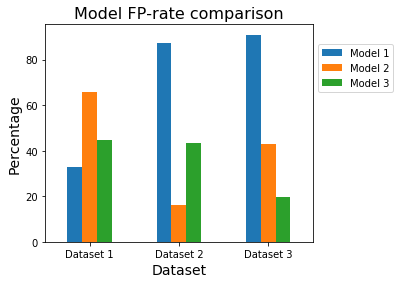

In [157]:
model_comparison_charts(model_FP_rate, "Model FP-rate comparison")

The False Positive rate of a model also known as FP rate is defined by FP-rate = FP / (FP + TN)<br>
From the comparison of Model 1, Model 2, and Model 3 on the basis of the false-positive rate in their classification, it seems that Model 3 performs the best.<br>
Model 1 seems to have about 90% of false positives when tested on other datasets.<br>
Model 2 which is trained on Dataset 2, gives the best performance on the same dataset, however, the false positive rate is  poor when tested on Dataset 1 and Dataset 3.<br>
Model 3 seems to have the best performance considering the FP-rate, the reason for this is the high skewness in the positive class data in the dataset3.<br>
As discussed above, one of the important parameters in the evaluation metrics considering the customer review classification is reducing false positives. Though other evaluation metrics should also be considered.<br>
A business owner follows up on negative customer reviews, and seeks to improve from negative customer reviews to retain those customers, they would strictly want to go through negative reviews they have received. Hence, a false positive in these cases will not be a good situation, wherein a negative review is classified incorrectly as positive.<br>
**From the perspective of FP-rate of the models, Model 3 seems to be the best model for classification.**

#### Comparison of Precision for all models

In [158]:
model_precision = pd.DataFrame({
    'Model 1' : ModelEvaluation_1["precision"],
    'Model 2' : ModelEvaluation_2["precision"],
    'Model 3' : ModelEvaluation_3["precision"]
})

In [159]:
model_precision

,Model 1,Model 2,Model 3
Dataset 1,89.31,73.46,75.73
Dataset 2,59.48,87.92,60.13
Dataset 3,58.59,58.41,87.04


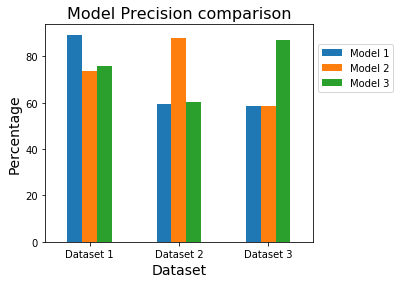

In [160]:
model_comparison_charts(model_precision, "Model Precision comparison")

The Precision of a model also known as Positive Predicted value is defined by Precision = TP / (TP + FP)<br>
The precision of the Model seems to be higher for the models which are trained and tested on the same datasets. Model 1, Model 2, Model 3, show higher precision when tested on Dataset 1, Dataset 2, Dataset 3 respectively.<br>
However, an important aspect is to consider how the model behaves when they are tested on different datasets.<br>
Model 1 gives an precision of about 90% when trained and tested on Dataset 1, whereas the precision is reduced to about 60% when tested on Dataset 2 & 3.<br>
Model 2 gives an precision of about 75% when tested on Dataset 1, whereas the model gives about 60% when tested on Dataset 3, Model 2 is trained on Dataset 2, hence the precision is about 90%.<br>
Model 3 shows about average precision when tested on other datasets,.i.e when Model 3 is tested on Dataset 1 and 2, it gives about 60% precision on each, where as the precision is highest when tested on Dataset 3 which is about 90%, as the model is trained on Dataset 3.<br>
**From precision perspective, selecting Model 1 and Model 3 make a good choice, however, other factors are also to be considered when making a model selection**

#### Comparison of Accuracy for all models

In [161]:
model_accuracy = pd.DataFrame({
    'Model 1' : ModelEvaluation_1["accuracy"],
    'Model 2' : ModelEvaluation_2["accuracy"],
    'Model 3' : ModelEvaluation_3["accuracy"]
})

In [162]:
model_accuracy

,Model 1,Model 2,Model 3
Dataset 1,88.5,58.2,52.45
Dataset 2,58.0,90.0,50.30
Dataset 3,57.7,49.2,86.75


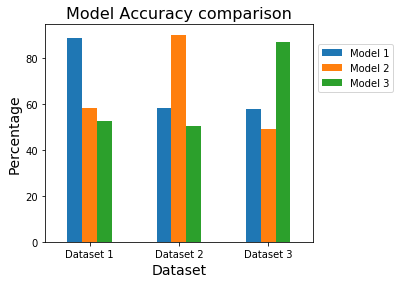

In [163]:
model_comparison_charts(model_accuracy, "Model Accuracy comparison")

Accuracy can be defined as total number of correct predictions among all the predictions, Accuracy = (TP + TN)/(TP + TN + FP + FN) <br> 
It considers all the correctly classified results.
The accuracy of the model 3 seems to be good, however, when considering the accuracy of the models when tested on other dataset they turn out to be just average- around 60%.<br>
When considering accuracy of the model, either of Model 1, Model 2 or Model 3 can be preferred.

#### Comparison of F-Score for all models

In [164]:
model_fscore = pd.DataFrame({
    'Model 1' : ModelEvaluation_1["fscore"],
    'Model 2' : ModelEvaluation_2["fscore"],
    'Model 3' : ModelEvaluation_3["fscore"]
})

In [165]:
model_fscore

,Model 1,Model 2,Model 3
Dataset 1,92.51,70.10,61.26
Dataset 2,71.51,91.34,52.07
Dataset 3,71.82,49.95,89.03


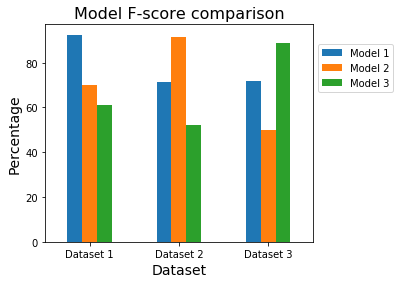

In [166]:
model_comparison_charts(model_fscore, "Model F-score comparison")

F-score is a metric that tries to balance between the precision and accuracy of the model. <br>
F-score = (2 * Precision * Recall)/(Precision+Recall) <br>
It is the harmonic mean of the precision and recall of the model.
The f-score for Model 1 seems to be the best, where as the worst f-score seems to be of the model 2.
Considering the F-score of the models, Model 1 seems to be the best and that of Model 3 seems to be just about same as model 1

## Conclusion:
**Model Selection** <br>
After going through different metrics like precision, false positives rate, accuracy, f-score it seems that Model 3 could be a good model as compared to Model 1 and Model 2 for classification of the customer reviews.<br> Model 3 is also better in terms of cross validation accuracy scores on the same as well as different datasets as compared to other models.<br>
Selection of model may vary from user to user, a user who wants to improve from feedback in negative reviews may focus on negative reviews and may want to select Model 3 which gives least false positives, ensures that a negative review is not incorrectly classified as positive. At the same time, ensures that precision and accuracy is not poor.<br>
I believe Model 3 will be a better choice as it maintains a balance between all the performance evaluation metrics and performs better than other models on unknown data.<br>

In [167]:
end_time = time.time()
run_time = (end_time - start_time)/60
run_time = round(run_time,2)
print("Total Time required to run the project: "+ str(run_time) +" minutes.")

Total Time required to run the project: 24.63 minutes.
